# Sections

[Objective](#Objective)  
[Setup](#Exploratory-analysis)  
[Load aata](#Load-data)  
[Clean and tokenize text](#Clean-and-tokenize-text)  
[Clustering](#Clustering)

- [KMeans](#KMeans)
- [NMF](#NMF)
- <a href='#agglomerative clustering'>Agglomerative (Ward)</a>

[Export clusters](#Export-clusters)  
[Scratchpad](#Scratchpad)

# Objective
[Back to top](#Sections)

#### How much interest will a new rental listing on RentHop receive?

In this Kaggle <a href='https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/data'>competition</a>, the aim is to predict how popular an apartment rental listing is based on the listing content like text description, photos, number of bedrooms, price, etc.

This workbook explores whether there are any insights to be gained from the text descripiton.

# Setup
[Back to top](#Sections)

In [8]:
from __future__ import print_function, division

In [9]:
from collections import OrderedDict
from collections import Counter
import numpy as np
import pandas as pd
import re
import seaborn as sns
import sys
import matplotlib.pyplot as plt
%matplotlib inline

Define functions for producing nicely formatted output.

In [10]:
# %load utils.py
from IPython.display import display, HTML

def pp_bold(str):
    display(HTML('<b>{}</b>'.format(str)))


def pp_listOflist(l):
    display(HTML(
        u'<table>{}</table>'.format(
            u''.join(u'<tr>{}</tr>'.format(
                u''.join(u'<td>{}</td>'.format(v) for v in sublist)) for sublist in l))))
    

def pp_dict(d, rows=None):
    if not rows or rows >= len(d):
        display(HTML(
            u'<table>{}</table>'.format(
                u''.join(u'<tr><td><b>{}</b></td><td>{}</td></tr>'.format(k, d[k]) for k in d))))
    else:
        nitems = len(d)
        width = -(-nitems // rows)
        i = 0
        list_ = [[] for _ in range(rows)]
        for _ in range(width):
            for row in range(rows):
                if i < nitems:
                    k, v = d.items()[i]
                    list_[row].extend(['<b>{}</b>'.format(k), v])
                i += 1
        pp_listOflist(list_)


def pp_dictOflist(d):
    display(HTML(
        u'<table>{}</table>'.format(
            u''.join(u'<tr><td><b>{}</b></td>{}</tr>'.format(k,
                u''.join(u'<td>{}</td>'.format(v) for v in d[k])) for k in d.keys()))))
    

def pp_dfinfo(df, width=4):
    ncols = len(df.columns)
    width = min(width, ncols)
    depth = -(-ncols // width)
    i = 0
    list_ = [[] for _ in range(depth)]
    for _ in range(width):
        for row in range(depth):
            if i < ncols:
                col = df.columns[i]
                list_[row].extend(['<b>{}</b>'.format(col), df[col].count(), df.dtypes[i]])
            i += 1

    print('{} entries, {} columns'.format(len(df), ncols))
    pp_listOflist(list_)


def pp_counts(series, rows=1, caption=None):
    if caption: pp_bold(caption)
    list_ = [(k, '{:.4f}'.format(v)) for k, v in series.to_dict().items()] 
    dict_ = OrderedDict(sorted(list_, key=lambda x: x[0]))
    pp_dict(dict_, rows)


def pp_progress(s):
    sys.stdout.write('\r{}'.format(s))
    sys.stdout.flush()


Define functions for creating plots and summary tables.

In [11]:
# %load plots.py
def percentplot(data, var, title=None, xlabel='', ax=None):
    ax = sns.barplot(x=var, y=var, data=data, estimator=lambda x: len(x) * 100 / len(data))
    ax.set(ylabel="Percent")
    ax.set(xlabel=xlabel if xlabel else '')
    ax.set(title=var if not title else title)
    return ax

    
def categoryplot(data, feature, category='interest_level', xlabel='', ax=None):
    values = pd.DataFrame()
    grouped = data.groupby([category, feature]).count()
    categories = data[category].cat.categories
    for c in categories:
        values[c] = grouped.xs(c).iloc[:,1]
    values = values.apply(lambda x: x * 100 / np.sum(x), axis=1)
    
    space = 0.1
    n = len(categories)
    width = (1.0 - space) / n
    
    xlabels = None
    for i, cat in enumerate(categories):
        percents = values.loc[:,cat]
        indices = range(len(percents))
        pos = [j - (1.0 - space) / n + i * width for j in indices]
        ax.bar(pos, percents, width=width, label=cat, color=sns.color_palette()[i])
        if i == 0:
            ax.set_xticks(indices)
            ax.set_xticklabels(percents.axes[0])

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1])
    ax.set_ylabel('percent')
    ax.set_xlabel(xlabel if xlabel else '')
    return ax


def feature_hist(df, column, title=None, xlabel='', rotation=None):
    fig = plt.figure(figsize=(10, 8))
    ax1 = percentplot(df, column, title, xlabel=xlabel, ax=plt.subplot(211))
    ax2 = categoryplot(df, column, xlabel=xlabel, ax=plt.subplot(212))
    if rotation:
        for item in ax1.get_xticklabels():
            item.set_rotation(rotation)
        for item in ax2.get_xticklabels():
            item.set_rotation(rotation)
    fig.tight_layout()


## Load data
[Back to top](#Sections)

Open listings database (see ```data_import.ipynb```)

In [12]:
from pymongo import MongoClient

In [13]:
client = MongoClient('ec2-34-198-246-43.compute-1.amazonaws.com', 27017)
db = client.renthop
collection = db.listings
pp_bold('{} listings'.format(collection.count()))

Print one of them.

In [14]:
pp_dict(collection.find_one())

listing_id,6818139
_id,58ac97520b0203c6b6436f4c
display_address,Hausman Street
description,"This one WON'T LAST!! Here is a stunning 3 Bedroom, 2 Full Bathroom apartment measuring approximately 1100 sqft! The layout is NOT a railroad with a King Sized master bedroom complete with on suite full bathroom and bay-windows. The 2nd and 3rd bedrooms can fit a Full or Queen sized bed and have over-sized windows. Thee is a second full bathroom with soaking tub off of the main hallway. Open concept kitchen with large island finished in real stone counters and soft close cabinetry plus Stainless Steel industrial sized appliances! Heated hardwood flooring throughout with tons of sunlight and space. Central HVAC means that you never have to be too hot or too cold again!One of the best locations for street parking in Greenpoint! Don't have a car? No Problem, the Nassau G Train and Grand St L train are within reach.Call, Text, Email Taylor now to schedule your private showing. Not exactly what you are looking for? Email me your search criteria, I Specialize in North Brooklyn!-------------Listing courtesy of Miron Properties. All material herein is intended for information purposes only and has been compiled from sources deemed reliable. Though information is believed to be correct, it is presented subject to errors, omissions, changes or withdrawal without notice. Miron Properties is a licensed Real Estate Broker. www.MironProperties.com<a website_redacted"
created,2016-04-03 02:22:45
price,2995
bedrooms,3
interest_level,medium
longitude,-73.9389
photos,https://photos.renthop.com/2/6818139_a50e80ff79c71a1ced4ec103985abdd9.jpg https://photos.renthop.com/2/6818139_a2be68c008aeff88347f97dc0350f85d.jpg https://photos.renthop.com/2/6818139_63166d3d69203d7bd63e8e8bb47db8c6.jpg https://photos.renthop.com/2/6818139_1aba230faec5ed91372bb3996b98acf1.jpg https://photos.renthop.com/2/6818139_af28eb103bab59ec9d929c3657d846e6.jpg https://photos.renthop.com/2/6818139_3637c3737c1286332310476fa4d5b1d8.jpg https://photos.renthop.com/2/6818139_83f4bfb1928581fb9feec154629f62e9.jpg
manager_id,198d2e96429920ff71cd06ddff323713


Copy listing, sans metadata, to dataframe.

In [15]:
%%time
c = collection.find({}, {'_id':0, 'id':0, 'building_id':0, 'manager_id':0, 'listing_id':0, 'photos':0})
raw_df = pd.DataFrame(list(c))
raw_df.interest_level = raw_df.interest_level.astype('category', categories=['low', 'medium', 'high'])

CPU times: user 968 ms, sys: 2.04 s, total: 3 s
Wall time: 51.6 s


## Clean and tokenize text
[Back to top](#Sections)

In [16]:
import nltk.corpus
import nltk.stem.porter
import re

The raw listing descriptions are polluted with HTML tags and formatting quirks:
- **```scrub```** removes meta data, symbols and extraneous text, and repairs formatting errors
- **```tokenize```** converts scrubbed text to words (tokens) with optional stemming.

In [17]:
regexs = [
    ('<!\[CDATA\[|<[^>]+>|<a.*?website_redacted', ' '), # drop HTML tags (e.g., <br>)
    ('&[a-z]+;', ' '), # drop HTML entities (e.g., &gt;)
    ('([A-Z]{2})([A-Z][a-z])', r'\1 \2'), # fix mixed caps: AMENITIESDoorman -> AMENITIES Doorman
    ('([a-z])([A-Z])', r'\1 \2'), # fix mixed caps (e.g., WasherDryer -> Washer Dryer)
    ('([0-9]{4})([a-zA-Z]{2})', r'\1 \2'), # fix mixed text and numbers: 9999XX -> 9999 XX
    ('([a-zA-Z]{2})([0-9]{2})', r'\1 \2'), # fix mixed text and numbers: XX99 -> XX 99
    (r'[/"`.,!?;:=&~+_#<>${}\r\*\(\)\|\[\]\-\\]', ' '), # drop punctuation
    ('[0-9]{2}[0-9]+[^a-zA-Z]', ' '), # drop long digit sequences
    (r'([^a-zA-Z])\'', r'\1'), # drop orphan apostrophe
    (r'\'([^a-zA-Z])', r'\1'), # drop orphan apostrophe
    # convert subway lines to longer words that survive tokenization
    (r' ([ABCDEFMGLJZNQRWS]) ', r' \1Line '),
    (r' ([ABCDEFMGLJZNQRWS]) ', r' \1Line '),
    (r' 1 ', ' one '),   (r' 2 ', ' two '),
    (r' 3 ', ' three '), (r' 4 ', ' four '),
    (r' 5 ', ' five '),  (r' 6 ', ' six '),
    (r' 7 ', ' seven '),
]

def scrub(text):
    for a, b in regexs:
        text = re.sub(a, b, text)
    return text

In [18]:
stemmer = nltk.stem.porter.PorterStemmer()
stems = {}
def get_stem(w):
    stem = stems.get(w, None)
    if not stem:
        stem = stemmer.stem(w).replace('\'', '')
        stems[w] = stem
    return stem

STOP_WORDS = """
    apartment unit
    email call contact text com kagglemanager@renthop www
    """
stops = set(STOP_WORDS.split()).union(nltk.corpus.stopwords.words('english'))

def tokenize(text, stemming=False):
    tokens = []
    for word in text.encode('ascii', 'ignore').lower().split():
        if word in stops:
            continue
        elif stemming:
            word = get_stem(word)
            if word in stops:
                continue
        tokens.append(word)
    return ' '.join(tokens)

Drop empty descriptions

In [19]:
df = raw_df.copy()
#no_description = df[df.description=='']
#df = df.drop(no_description.index)
#pp_bold('Ignoring {} listings, {} remain'.format(len(no_description), len(df)))

Scrub and tokenize the listings.

In [20]:
%%time
df['scrubbed'] = df.description.apply(lambda x: scrub(x))
df['tokens'] = df.scrubbed.apply(lambda x: tokenize(x))

CPU times: user 12.5 s, sys: 0 ns, total: 12.5 s
Wall time: 12.4 s


Here's what we're left with.

In [21]:
descriptions = df.tokens.apply(lambda x: x.split() if x else np.nan).dropna()
unique_words = Counter([word for listing in descriptions for word in listing])
repeat_words = sum([1 for word, count in unique_words.items() if count > 1])
total_words = np.sum(descriptions.apply(lambda x: len(x)))
median_len = np.median(descriptions.apply(lambda x: len(x)))
pp_dict(OrderedDict([
        ('descriptions', len(descriptions)), 
        ('total words', total_words), 
        ('unique words', len(unique_words)),
        ('repeated words', repeat_words),
        ('median length', np.round(median_len))]))

descriptions,45683
total words,2895612
unique words,24428
repeated words,15495
median length,56.0


 And here's an example of how the text is transformed.

In [22]:
example = OrderedDict()
for col in ['description', 'scrubbed', 'tokens']:
    example[col] = df[col][282].replace('<', '&lt;').replace('>', '&gt;')
pp_dict(example)

description,"Loft like 12 ft CeilingsOversized, energy efficient windowsGranite & Porcelain gourmet KitchenPolished chrome fixtures throughoutMinutes from A,C,2,3,4,5,J,Z,R Trains!Minutes from Wall St, Seaport, Stone St<br /><br />Elevator / 24 Hr DoormanFitness CenterGreat Roofdeck for summerShoot Pool in Tenant's LoungeImmaculately restored Lobby<br /><br />To schedule a viewing please call or text Justin @ 498-701-6489 or email at kagglemanager@renthop.com<br /><br /><p><a website_redacted"
scrubbed,Loft like 12 ft Ceilings Oversized energy efficient windows Granite Porcelain gourmet Kitchen Polished chrome fixtures throughout Minutes from ALine CLine two three four five JLine ZLine RLine Trains Minutes from Wall St Seaport Stone St Elevator 24 Hr Doorman Fitness Center Great Roofdeck for summer Shoot Pool in Tenant's Lounge Immaculately restored Lobby To schedule a viewing please call or text Justin @ or email at kagglemanager@renthop com
tokens,loft like 12 ft ceilings oversized energy efficient windows granite porcelain gourmet kitchen polished chrome fixtures throughout minutes aline cline two three four five jline zline rline trains minutes wall st seaport stone st elevator 24 hr doorman fitness center great roofdeck summer shoot pool tenant's lounge immaculately restored lobby schedule viewing please justin @


## Clustering
[Back to top](#Sections)

Let's see what NLP clustering can tell us. First import all the scikit-learn modules we'll be using.

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.externals import joblib

Create the requisite TF-IDF matrix of [n_samples, n_features]. I hand-tuned **max_df** and **max_df** to elmininate rare words, and also common words that appear so often as to be meaningless. The resulting matrix has ~1300 n-grams. 

In [55]:
params = {
    'min_df' : .01, 'max_df' : 0.8, 'max_features' : 200000, 'ngram_range' : (1,2)
    }
tfidf_vectorizer = TfidfVectorizer(**params)
%time tfidf_matrix = tfidf_vectorizer.fit_transform(df.tokens)
print(tfidf_matrix.shape)

CPU times: user 12.6 s, sys: 332 ms, total: 12.9 s
Wall time: 12.9 s
(49352, 1325)


### KMeans
[Back to top](#Sections)

With KMeans, you specify how many clusters to create. As I don't know beforehand, try different values and examine the resulting silhouette and inertia scores. To save time, use a subset of the data and precompute the pairwise distances.

In [31]:
km_sample = tfidf_matrix[:5000]
km_distances = pairwise_distances(km_sample, metric='cosine')

In [32]:
km_scores = { 'silhouette' : [], 'inertia' : [] }
km_params = { 'n_clusters' : 0, 'random_state' : 4444, 'init' : 'k-means++', 'n_jobs' : -1}
km_range = range(2, 21)
for n_clusters in km_range:
    pp_progress('Fitting KMeans with {} clusters ... '.format(n_clusters))
    km_params['n_clusters'] = n_clusters
    km = KMeans(**km_params)
    km.fit(km_sample)
    km_scores['silhouette'].append(silhouette_score(km_distances, km.labels_, metric='precomputed'))
    km_scores['inertia'].append(km.inertia_)
print('done')

Fitting KMeans with 20 clusters ... done


Here I plot the results.

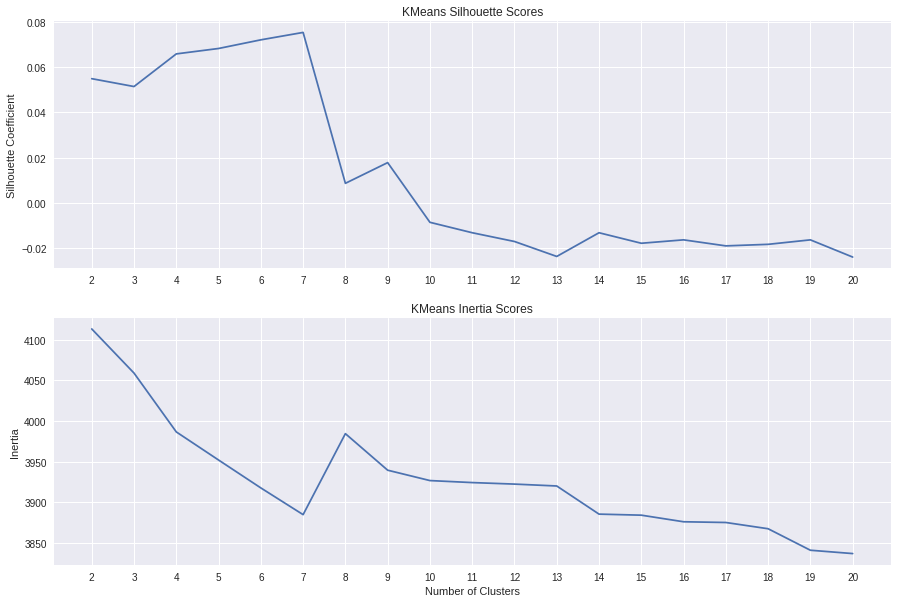

In [33]:
plt.figure(figsize=(15, 10))

ax = plt.subplot(211)
plt.plot(km_range, km_scores['silhouette'])
plt.xticks(km_range, km_range)
ax.set(title='KMeans Silhouette Scores', ylabel='Silhouette Coefficient')

ax = plt.subplot(212)
plt.plot(km_range, km_scores['inertia'])
plt.xticks(km_range, km_range)
ax.set(title="KMeans Inertia Scores", xlabel='Number of Clusters', ylabel='Inertia')
plt.show()

I'd rather have more clusters (assuming they're evenly populated) so here I fit the entire dataset to 13 clusters.

In [34]:
%%time
params = {'n_clusters' : 13, 'random_state' : 4444,  'init' : 'k-means++', 'n_jobs' : -1}
km = KMeans(**params)
km.fit(tfidf_matrix)

CPU times: user 1.95 s, sys: 1.37 s, total: 3.32 s
Wall time: 12min 26s


In [242]:
#joblib.dump(km, './data/KMeans.pkl')
km = joblib.load('./data/KMeans.pkl')

The table below contains the ten most common words in each cluster. Clusters 3, 5, 7 and 10 appear to identify specific agencies (Bond, Cooper and Miron). Of the remaining, these have easily identifed features:
- cluster 0: fitness center, amenities, views, concierge
- cluster 2: east side, west side
- cluster 4: one month free
- cluster 11: exposed brick, hardwood floors, washer/dryer
- cluster 12: heat and hot water included

In [229]:
topics = {}
words = np.asarray(tfidf_vectorizer.get_feature_names())
for r in km.cluster_centers_:
    feature_importances = r.argsort()[::-1]
    topics[len(topics)] = ', '.join(words[feature_importances][:10])
pp_dict(topics, rows=4)

How do the clusters align with our target variable? It's a mixed bag. The Cooper cluster (five) is strongly correlated with low interest, but it's only 1% of the data. So is cluster seven, but the correlation is not as strong. Of the others, clusters four, six, eight and twelve deviate from the overall percentages.

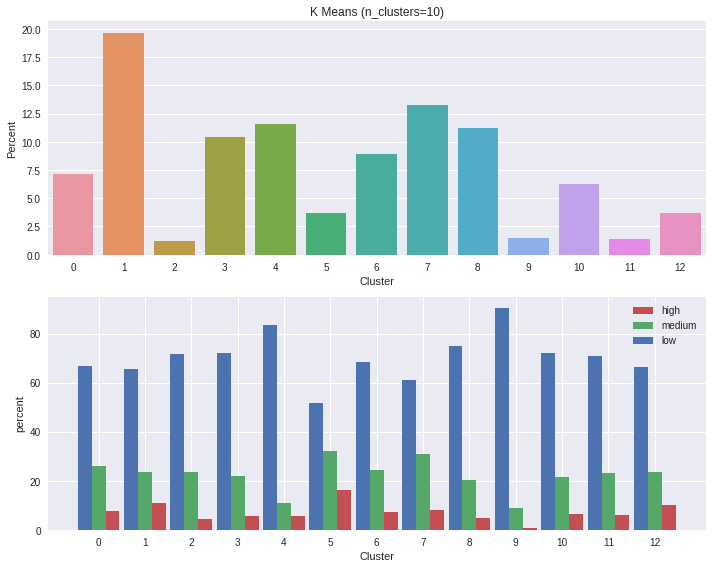

In [230]:
df['km_clusters'] = km.labels_.tolist()
feature_hist(df, 'km_clusters', 'K Means (n_clusters=10)', xlabel='Cluster')
pp_counts(df.km_clusters.value_counts(normalize=True), caption='K Means Clusters:', rows=2)

### NMF
[Back to top](#Sections)

KMeans gave mixed results, so try NMF. It also requires that you specify how many clusters to create, so again try several and plot the results. The curve flattens at 20 clusters.

In [38]:
nmf_sample = tfidf_matrix[:5000]
nmf_distances = pairwise_distances(nmf_sample, metric='euclidean')

In [39]:
nmf_scores = { 'silhouette' : [] }
nmf_params = { 'n_components' : 0, 'random_state' : 4444 }
nmf_range = range(2, 31)

for n_components in nmf_range:
    pp_progress('Fitting NMF with {} clusters ... '.format(n_components))
    nmf_params['n_components'] = n_components
    nmf = NMF(**nmf_params)
    nmf_factors = nmf.fit_transform(nmf_sample)
    nmf_labels = nmf_factors.argmax(axis=1)
    nmf_scores['silhouette'].append(silhouette_score(nmf_distances, nmf_labels, metric='precomputed'))
print('done')

Fitting NMF with 30 clusters ... done


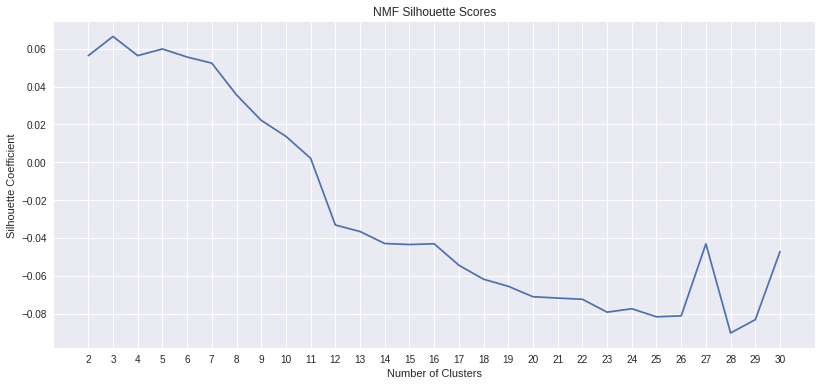

In [40]:
plt.figure(figsize=(30,6))
ax = plt.subplot(121)
plt.plot(nmf_range, nmf_scores['silhouette'])
plt.xticks(nmf_range, nmf_range)
ax.set(title='NMF Silhouette Scores', xlabel='Number of Clusters', ylabel='Silhouette Coefficient')
plt.show()

In [235]:
%%time
params = { 'n_components' : 22, 'random_state' : 4444 }
nmf = NMF(**params)
nmf_factors = nmf.fit_transform(tfidf_matrix)

CPU times: user 18.5 s, sys: 16.8 s, total: 35.3 s
Wall time: 16.4 s


In [236]:
joblib.dump(nmf, './data/NMF.pkl')
#nmf = joblib.load('./data/NMF.pkl')

['./data/NMF.pkl']

Here are the most common words in each cluster.

In [237]:
topics = {}
words = np.asarray(tfidf_vectorizer.get_feature_names())
for r in nmf.components_:
    feature_importances = r.argsort()[::-1]
    topics[len(topics)] = ', '.join(words[feature_importances][:10])
pp_dict(topics, rows=5)

How do the clusters align with our target variable? 

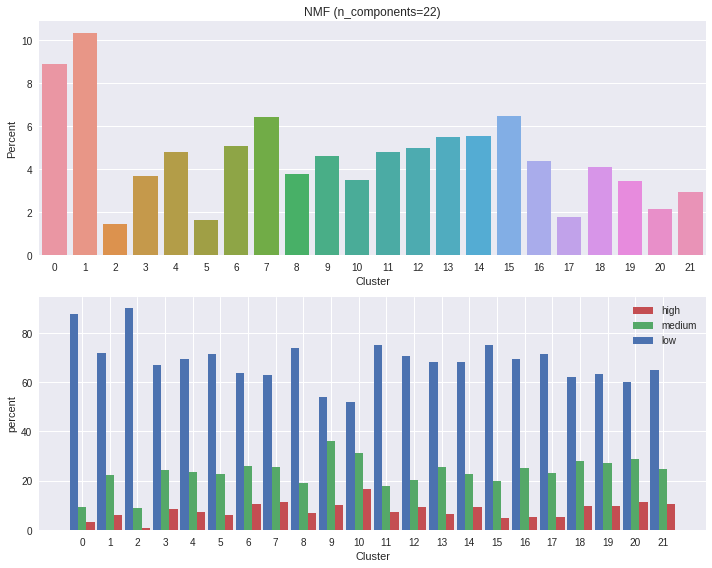

In [238]:
df['nmf_clusters'] = np.argmax(nmf_factors, axis=1)
feature_hist(df, 'nmf_clusters', title='NMF (n_components=22)', xlabel='Cluster')
pp_counts(df.nmf_clusters.value_counts(normalize=True), caption='NMF Clusters:', rows=3)

<a id='agglomerative clustering'></a>
### Agglomerative (Ward) 
[Back to top](#Sections)

In [45]:
ward_sample = tfidf_matrix[:5000].toarray()
ward_distances = pairwise_distances(ward_sample, metric='cosine')

In [46]:
ward_scores = { 'silhouette' : [] }
ward_params = { 'n_clusters' : 0, 'linkage' : 'ward'}
ward_range = range(2, 21)

for n_clusters in ward_range:
    pp_progress('Fitting Ward with {} clusters ... '.format(n_clusters))
    ward_params['n_clusters'] = n_clusters
    ward = AgglomerativeClustering(**ward_params)
    ward.fit(ward_sample)
    ward_scores['silhouette'].append(silhouette_score(ward_distances, ward.labels_, metric='precomputed'))
print('done')

Fitting Ward with 20 clusters ... done


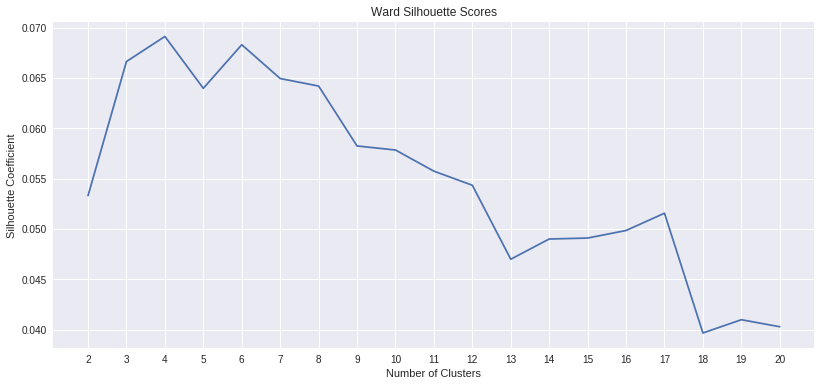

In [47]:
plt.figure(figsize=(30,6))
ax = plt.subplot(121)
plt.plot(ward_range, ward_scores['silhouette'])
plt.xticks(ward_range, ward_range)
ax.set(title='Ward Silhouette Scores', xlabel='Number of Clusters', ylabel='Silhouette Coefficient')
plt.show()

In [48]:
%%time
ward_total = 20000
params = { 'n_clusters' : 17, 'linkage' : 'ward' }
ward = AgglomerativeClustering(**params)
ward.fit(tfidf_matrix[:ward_total].toarray())

CPU times: user 10min 27s, sys: 2min 58s, total: 13min 25s
Wall time: 13min 31s


In [3]:
#joblib.dump(ward, './data/Ward.pkl')
ward = joblib.load('./data/Ward.pkl')

Here are the most common words in each cluster.

In [221]:
def get_centroid(matrix, rows):
    centroid = matrix[rows[0]]
    for row in matrix[rows[1:]]:
        centroid = centroid + row
    centroid = centroid / len(rows)
    return centroid.toarray()[0]

topics = {}
words = np.asarray(tfidf_vectorizer.get_feature_names())
for i in range(ward.n_clusters):
    rows = df[df.ward_clusters==i].index
    centroid = get_centroid(tfidf_matrix, rows)
    feature_importances = centroid.argsort()[::-1]
    topics[i] = ', '.join(words[feature_importances][:10])
pp_dict(topics, rows=6)

How do the clusters align with our target variable? 

0.0,0.0272,1.0,0.2106,2.0,0.0614,3.0,0.0037,4.0,0.1042,5.0,0.0975,6.0,0.0066,7.0,0.0037,8.0,0.0138,9.0,0.0045,10.0,0.3462,11.0,0.0138,12.0,0.0115,13.0,0.0124,14.0,0.0771,15.0,0.0029,16.0,0.0028


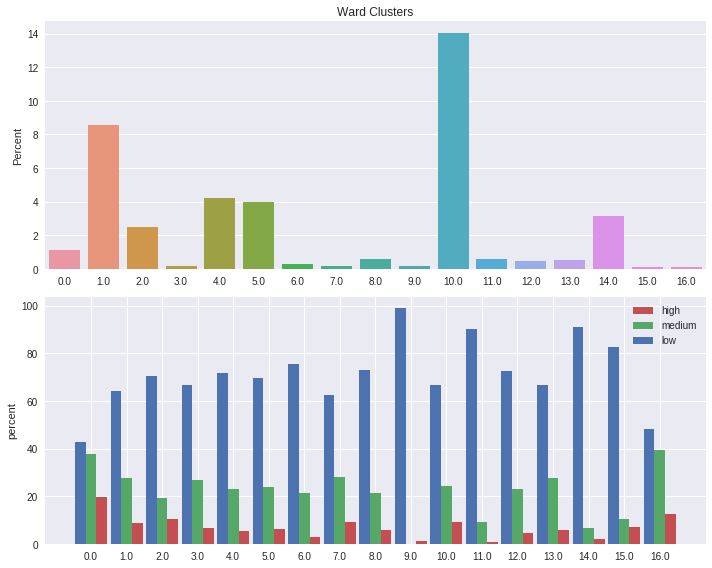

In [222]:
df['ward_clusters'] = np.append(ward.labels_, [np.nan]*(len(df)-ward_total))
feature_hist(df, 'ward_clusters', 'Ward Clusters')
pp_counts(df.ward_clusters.value_counts(normalize=True), caption='Ward Clusters:')

## Export clusters
[Back to top](#Sections)
Export samples and clusters for d3/Flask app

In [240]:
import json
def get_size(bed, bath):
    if 0 == bed:
        return 'Studio'
    else:
        return '{}BR, {}BA'.format(bed, int(bath) if int(bath) == bath else bath)

In [275]:
cols = ['km_clusters', 'nmf_clusters', 'ward_clusters', 
        'price', 'size', 'street_address', 'description']

sample = df[df.tokens!=''].sample(1000, random_state=4444)
sample_tfidf_matrix = tfidf_matrix[sample.index]
sample.reset_index(inplace=True, drop=True)
sample.ward_clusters = sample.ward_clusters.fillna(-1)
sample['size'] = [get_size(sample.bedrooms.iloc[i], sample.bathrooms.iloc[i]) for i in range(len(sample))]
sample[cols].to_json('./app/nodes.json', orient='index')

# KMeans

km_clusters = []
for i, r in enumerate(km.cluster_centers_):
    rows = sample[sample.km_clusters==i]
    if 0 < len(rows):
        feature_importances = r.argsort()[::-1]
        top_words = ', '.join(words[feature_importances][:10])
        km_clusters.append({'name' : i, 'size' : len(rows), 'words' : top_words})

with open('./app/KMeans_clusters.json', 'w') as fp:
    json.dump({'name' : 'root', 'children' : km_clusters}, fp);

# NMF
    
nmf_clusters = []
for i, r in enumerate(nmf.components_):
    rows = sample[sample.nmf_clusters==i]
    if 0 < len(rows):
        feature_importances = r.argsort()[::-1]
        top_words = ', '.join(words[feature_importances][:10])
        nmf_clusters.append({'name' : i, 'size' : len(rows), 'words' : top_words})

with open('./app/NMF_clusters.json', 'w') as fp:
    json.dump({'name' : 'root', 'children' : nmf_clusters}, fp);

# Ward

ward_clusters = []
for i in range(ward.n_clusters):
    rows = sample[sample.ward_clusters==i].index
    if 0 < len(rows):
        centroid = get_centroid(sample_tfidf_matrix, rows)
        feature_importances = centroid.argsort()[::-1]
        top_words = ', '.join(words[feature_importances][:10])
        ward_clusters.append({'name' : i, 'size' : len(rows), 'words' : top_words})

with open('./app/Ward_clusters.json', 'w') as fp:
    json.dump({'name' : 'root', 'children' : ward_clusters}, fp);

## Scratchpad
[Back to top](#Sections)

#### DBSCAN

In [ ]:
from sklearn.preprocessing import normalize
tfidf_normed = normalize(tfidf_matrix)

In [ ]:
%%time
from sklearn.preprocessing import StandardScaler
params = { 'eps' : 5.0, 'min_samples' : 4, 'n_jobs' : -1}
n_clusters = []
#for eps in range(900, 1000):
#    params['eps']=eps/1000.0
dbscan = DBSCAN(**params)
dbscan.fit(tfidf_normed)
#    n_clusters.append(len(dbscan.labels_))
    

In [ ]:
clusters = dbscan.labels_
temp = df[:5000].copy()
temp['clusters'] = clusters
feature_hist(temp, 'clusters', 'DBSCAN Clusters')
pp_counts(temp.clusters.value_counts(normalize=True), caption='DBSCAN Clusters:')